# Phase 4 Project

## Time Series Model

Let us start by loading the datasets and see what type of data we are dealing with

In [3]:
import pandas as pd
import numpy as np
#pd.set_option('display.max_rows', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

First the Dataset about Temperatures:

In [4]:
df2_tempcounty=pd.read_csv('archive (2)/GlobalLandTemperaturesByCountry.csv')

In [5]:
df2_tempcounty

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland
...,...,...,...,...
577457,2013-05-01,19.059,1.022,Zimbabwe
577458,2013-06-01,17.613,0.473,Zimbabwe
577459,2013-07-01,17.000,0.453,Zimbabwe
577460,2013-08-01,19.759,0.717,Zimbabwe


In [6]:
df2_tempcity=pd.read_csv('archive (2)/GlobalLandTemperaturesByMajorCity.csv')

In [7]:
df2_tempcity

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W
...,...,...,...,...,...,...,...
239172,2013-05-01,18.979,0.807,Xian,China,34.56N,108.97E
239173,2013-06-01,23.522,0.647,Xian,China,34.56N,108.97E
239174,2013-07-01,25.251,1.042,Xian,China,34.56N,108.97E
239175,2013-08-01,24.528,0.840,Xian,China,34.56N,108.97E


In [8]:
df2=pd.read_csv('archive (2)/GlobalTemperatures.csv')
df2

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3187,2015-08-01,14.755,0.072,20.699,0.110,9.005,0.170,17.589,0.057
3188,2015-09-01,12.999,0.079,18.845,0.088,7.199,0.229,17.049,0.058
3189,2015-10-01,10.801,0.102,16.450,0.059,5.232,0.115,16.290,0.062
3190,2015-11-01,7.433,0.119,12.892,0.093,2.157,0.106,15.252,0.063


In [10]:
df2_state=pd.read_csv('archive (2)/GlobalLandTemperaturesByState.csv')
df2_state

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil
...,...,...,...,...,...
645670,2013-05-01,21.634,0.578,Zhejiang,China
645671,2013-06-01,24.679,0.596,Zhejiang,China
645672,2013-07-01,29.272,1.340,Zhejiang,China
645673,2013-08-01,29.202,0.869,Zhejiang,China


Now let's move on to the dataset about solar energy

In [4]:
dfsolar=pd.read_csv('solarenergy.csv',index_col='Datetime', parse_dates=True)
dfsolar

/Users/vi/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,solar_mw,wind-direction,wind-speed,humidity,average-wind-speed-(period),average-pressure-(period),temperature
Datetime,,,,,,,
2020-03-08 00:00:00,11385,27,7.5,75.0,8.0,29.82,69.0
2020-02-08 23:00:00,12390,27,7.5,77.0,5.0,29.85,69.0
2020-02-08 22:00:00,13312,27,7.5,70.0,0.0,29.89,69.0
2020-02-08 21:00:00,13832,27,7.5,33.0,0.0,29.91,69.0
2020-02-08 20:00:00,14038,27,7.5,21.0,3.0,29.89,69.0
...,...,...,...,...,...,...,...
2007-01-05 05:00:00,6445,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-05 04:00:00,6452,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-05 03:00:00,6583,NaN,NaN,NaN,NaN,NaN,NaN


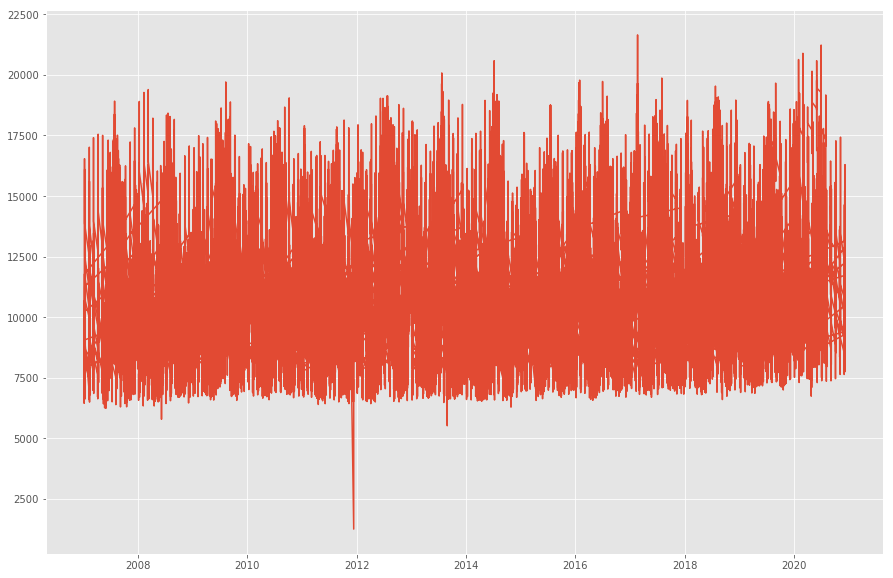

In [9]:
fig = plt.figure(figsize=(15,10))
plt.plot(dfsolar['solar_mw'])
plt.show();

In [22]:
solar=dfsolar['solar_mw']['2016':'2020']

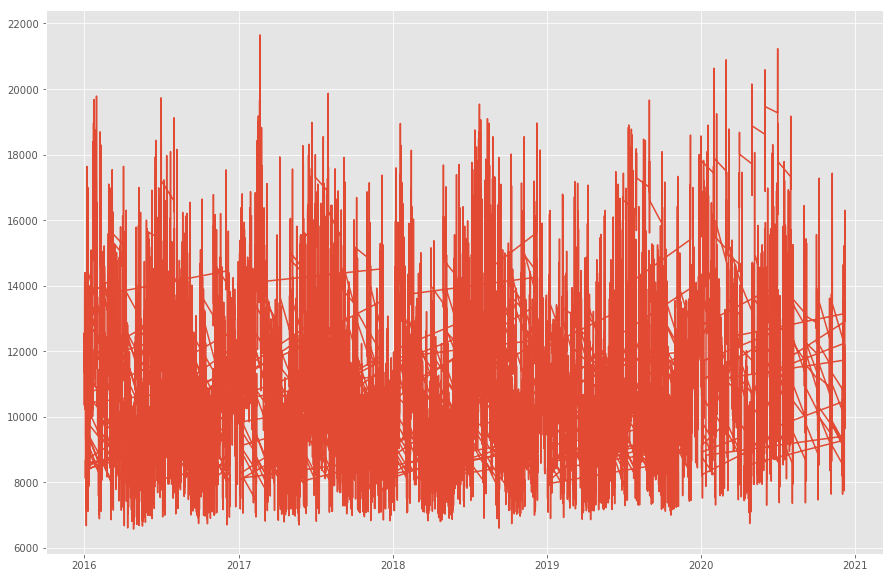

In [23]:
fig = plt.figure(figsize=(15,10))
plt.plot(solar)
plt.show()

In [24]:
solar

Datetime
2020-03-08 00:00:00    11385
2020-02-08 23:00:00    12390
2020-02-08 22:00:00    13312
2020-02-08 21:00:00    13832
2020-02-08 20:00:00    14038
                       ...  
2016-01-01 04:00:00    11436
2016-01-01 03:00:00    11363
2016-01-01 02:00:00    11415
2016-01-01 01:00:00    11481
2016-01-01 00:00:00    11696
Name: solar_mw, Length: 40176, dtype: int64

On to US energy generation

In [15]:
USen=pd.read_csv('archive (3)/organised_Gen.csv')

In [16]:
USen

,Unnamed: 0,YEAR,MONTH,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
0,0,2001,1,AK,Total Electric Power Industry,Coal,46903.0
1,1,2001,1,AK,Total Electric Power Industry,Petroleum,71085.0
2,2,2001,1,AK,Total Electric Power Industry,Natural Gas,367521.0
3,3,2001,1,AK,Total Electric Power Industry,Hydroelectric Conventional,104549.0
4,4,2001,1,AK,Total Electric Power Industry,Wind,87.0
...,...,...,...,...,...,...,...
496769,10581,2022,5,WY,"Electric Generators, Electric Utilities",Coal,2071403.0
496770,10582,2022,5,WY,"Electric Generators, Electric Utilities",Hydroelectric Conventional,96790.0
496771,10583,2022,5,WY,"Electric Generators, Electric Utilities",Natural Gas,91570.0
496772,10584,2022,5,WY,"Electric Generators, Electric Utilities",Petroleum,1812.0


Very interesting! Could pick a couple of energy sources and analyze them in parallel

In [18]:
USenstates=pd.read_csv('archive (3)/states.csv')
USenstates.head()

,State,Abbrev,Code
0,Alabama,Ala.,AL
1,Alaska,Alaska,AK
2,Arizona,Ariz.,AZ
3,Arkansas,Ark.,AR
4,California,Calif.,CA


ok sure

In [25]:
USen['ENERGY SOURCE'].value_counts()

Total                             73356
Natural Gas                       66684
Petroleum                         63176
Coal                              47642
Other Biomass                     46148
Hydroelectric Conventional        38842
Other                             36241
Wood and Wood Derived Fuels       30524
Wind                              25421
Solar Thermal and Photovoltaic    19393
Other Gases                       18212
Nuclear                           16754
Pumped Storage                    10139
Geothermal                         4242
Name: ENERGY SOURCE, dtype: int64

In [30]:
TX=USen.loc[USen['STATE']=='TX']
#dataframe.loc[dataframe['Percentage'] > 70] 
TX

,Unnamed: 0,YEAR,MONTH,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
1329,1329,2001,1,TX,Total Electric Power Industry,Coal,11683911.0
1330,1330,2001,1,TX,Total Electric Power Industry,Petroleum,1428770.0
1331,1331,2001,1,TX,Total Electric Power Industry,Natural Gas,13750546.0
1332,1332,2001,1,TX,Total Electric Power Industry,Other Gases,146044.0
1333,1333,2001,1,TX,Total Electric Power Industry,Nuclear,3545310.0
...,...,...,...,...,...,...,...
496431,10243,2022,5,TX,"Electric Generators, Electric Utilities",Petroleum,2177.0
496432,10244,2022,5,TX,"Electric Generators, Electric Utilities",Solar Thermal and Photovoltaic,2177.0
496433,10245,2022,5,TX,"Electric Generators, Electric Utilities",Other Biomass,0.0
496434,10246,2022,5,TX,"Electric Generators, Electric Utilities",Wind,26347.0


In [ ]:
TX['ENERGY SOURCE']

In [34]:
TX_oil=TX.loc[TX['ENERGY SOURCE']=='Petroleum']

In [37]:
TX_oil["Date"] = TX_oil['YEAR'].astype(str) +"-"+ TX_oil["MONTH"].astype(str)

/Users/vi/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
TX_oil

,Unnamed: 0,YEAR,MONTH,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours),Date
1330,1330,2001,1,TX,Total Electric Power Industry,Petroleum,1428770.0,2001-1
1342,1342,2001,1,TX,"Electric Generators, Electric Utilities",Petroleum,1317036.0,2001-1
1349,1349,2001,1,TX,"Electric Generators, Independent Power Producers",Petroleum,261.0,2001-1
1356,1356,2001,1,TX,"Combined Heat and Power, Electric Power",Petroleum,101277.0,2001-1
1360,1360,2001,1,TX,"Combined Heat and Power, Commercial Power",Petroleum,337.0,2001-1
...,...,...,...,...,...,...,...,...
496391,10203,2022,5,TX,Total Electric Power Industry,Petroleum,12907.0,2022-5
496400,10212,2022,5,TX,"Combined Heat and Power, Industrial Power",Petroleum,9348.0,2022-5
496408,10220,2022,5,TX,"Combined Heat and Power, Commercial Power",Petroleum,0.0,2022-5
496422,10234,2022,5,TX,"Electric Generators, Independent Power Producers",Petroleum,1382.0,2022-5


In [39]:
TX_oilf=TX_oil.loc[TX_oil['TYPE OF PRODUCER']=='Total Electric Power Industry']

In [40]:
TX_oilf

,Unnamed: 0,YEAR,MONTH,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours),Date
1330,1330,2001,1,TX,Total Electric Power Industry,Petroleum,1428770.0,2001-1
3001,3001,2001,2,TX,Total Electric Power Industry,Petroleum,303792.0,2001-2
4675,4675,2001,3,TX,Total Electric Power Industry,Petroleum,213414.0,2001-3
6352,6352,2001,4,TX,Total Electric Power Industry,Petroleum,133996.0,2001-4
8031,8031,2001,5,TX,Total Electric Power Industry,Petroleum,117381.0,2001-5
...,...,...,...,...,...,...,...,...
487922,1734,2022,1,TX,Total Electric Power Industry,Petroleum,12474.0,2022-1
490041,3853,2022,2,TX,Total Electric Power Industry,Petroleum,26279.0,2022-2
492158,5970,2022,3,TX,Total Electric Power Industry,Petroleum,13208.0,2022-3
494274,8086,2022,4,TX,Total Electric Power Industry,Petroleum,10432.0,2022-4


In [42]:
TX_oilf.rename(columns={6: "t"}, inplace=True)

/Users/vi/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


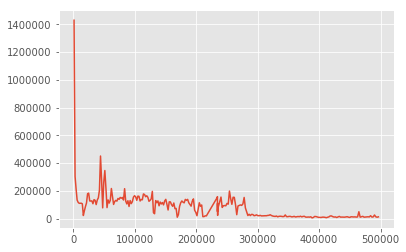

In [45]:
TX_oilf['GENERATION (Megawatthours)'].plot();

/Users/vi/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/vi/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/vi/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


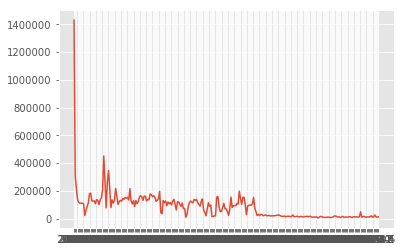

In [46]:
plt.plot(TX_oilf['Date'],TX_oilf['GENERATION (Megawatthours)'])

In [47]:
TX_oilf['GENERATION (Megawatthours)']

1330      1428770.0
3001       303792.0
4675       213414.0
6352       133996.0
8031       117381.0
            ...    
487922      12474.0
490041      26279.0
492158      13208.0
494274      10432.0
496391      12907.0
Name: GENERATION (Megawatthours), Length: 257, dtype: float64

In [48]:
TX_oilg=TX_oilf.iloc[1: , :]

In [49]:
TX_oilg

,Unnamed: 0,YEAR,MONTH,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours),Date
3001,3001,2001,2,TX,Total Electric Power Industry,Petroleum,303792.0,2001-2
4675,4675,2001,3,TX,Total Electric Power Industry,Petroleum,213414.0,2001-3
6352,6352,2001,4,TX,Total Electric Power Industry,Petroleum,133996.0,2001-4
8031,8031,2001,5,TX,Total Electric Power Industry,Petroleum,117381.0,2001-5
9715,9715,2001,6,TX,Total Electric Power Industry,Petroleum,110543.0,2001-6
...,...,...,...,...,...,...,...,...
487922,1734,2022,1,TX,Total Electric Power Industry,Petroleum,12474.0,2022-1
490041,3853,2022,2,TX,Total Electric Power Industry,Petroleum,26279.0,2022-2
492158,5970,2022,3,TX,Total Electric Power Industry,Petroleum,13208.0,2022-3
494274,8086,2022,4,TX,Total Electric Power Industry,Petroleum,10432.0,2022-4


In [53]:
TX_oilg['Date']

3001      2001-2
4675      2001-3
6352      2001-4
8031      2001-5
9715      2001-6
           ...  
487922    2022-1
490041    2022-2
492158    2022-3
494274    2022-4
496391    2022-5
Name: Date, Length: 256, dtype: object

/Users/vi/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/vi/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/vi/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


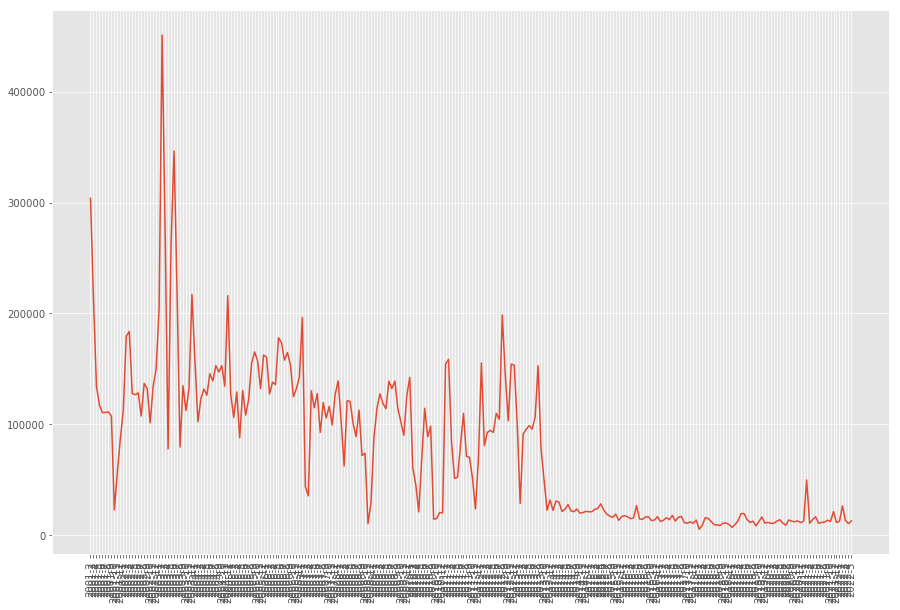

In [52]:
fig = plt.figure(figsize=(15,10))
#plt.plot(solar)
plt.plot(TX_oilg['Date'],TX_oilg['GENERATION (Megawatthours)'])
plt.xticks(rotation=90)
plt.show()

In [54]:
TX_oila=TX_oilf.loc[TX_oilf['YEAR']>2010]

/Users/vi/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/vi/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/vi/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


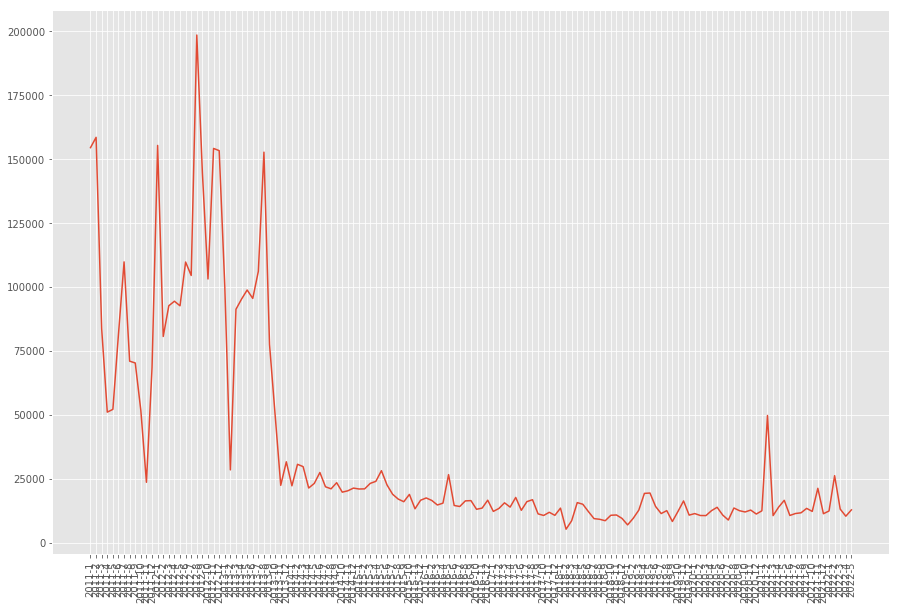

In [55]:
fig = plt.figure(figsize=(15,10))
#plt.plot(solar)
plt.plot(TX_oila['Date'],TX_oila['GENERATION (Megawatthours)'])
plt.xticks(rotation=90)
plt.show()